In [20]:
# =========================================================
# 🔧 Import HistoDataset depuis le projet local
# =========================================================
import sys, os
from pathlib import Path

# --- Emplacement du projet quand on lance depuis notebooks/ ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "02_baseline_cnn"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "02_baseline_cnn"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "02_baseline_cnn"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "02_baseline_cnn"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Ajoute la racine du projet au PYTHONPATH pour pouvoir faire "import p9dg"
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Aussi l'accès direct au dossier p9dg
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

# Import du dataset
from histo_dataset import HistoDataset

print(f"✅ Module histo_dataset importé depuis : {DATAGENERATOR_PATH}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_ROOT: {DATA_ROOT}")
print(f"CONFIG_DIR: {CONFIG_DIR}")


✅ Module histo_dataset importé depuis : /workspace/p9dg
PROJECT_ROOT: /workspace
DATA_ROOT: /workspace/data
CONFIG_DIR: /workspace/configs


In [2]:
# Utiliser CONFIG_DIR et DATA_ROOT définis dans la cellule précédente
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
DATASET_DIR = DATA_ROOT  # Alias pour compatibilité

In [3]:
# forçage methode spawn (fix problème multiprocessing)
import torch.multiprocessing as mp
if mp.get_start_method(allow_none=True) != "spawn":
    mp.set_start_method("spawn", force=True)

In [4]:
from histo_dataset import HistoDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Fonction de création d'un writer pour Tensorboard
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

def create_writer(model_name, image_size, samples_per_class, vahadane_enable,
                  base_dir=None):
    """
    Crée un SummaryWriter TensorBoard avec un nom de run auto-généré,
    dans RUNS_DIR (défini globalement).
    """
    from pathlib import Path
    # Utiliser RUNS_DIR défini dans la cellule précédente
    if base_dir is None:
        # Vérifier si RUNS_DIR existe dans globals() avant de l'utiliser
        if "RUNS_DIR" in globals():
            runs_dir = globals()["RUNS_DIR"]
        else:
            # Si PROJECT_ROOT n'existe pas non plus, le définir
            if "PROJECT_ROOT" in globals():
                project_root = globals()["PROJECT_ROOT"]
            else:
                project_root = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
            runs_dir = project_root / "runs" / "02_baseline_cnn"
        base_dir = runs_dir
    else:
        base_dir = Path(base_dir)
    
    base_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    norm_tag = "vahadane" if vahadane_enable else "nonorm"
    run_name = f"{model_name}_{image_size}px_{samples_per_class or 'full'}pc_{norm_tag}_{timestamp}"
    
    # ✅ Construction d’un chemin absolu garanti
    log_dir = os.path.normpath(os.path.join(base_dir, run_name))
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir=str(log_dir))

    info_text = (
        f"**Run name:** {run_name}\n\n"
        f"**Model:** {model_name}\n"
        f"**Image size:** {image_size}px\n"
        f"**Samples per class (train):** {samples_per_class or 'full dataset'}\n"
        f"**Normalization:** {'Vahadane' if vahadane_enable else 'None'}\n"
        f"**Timestamp:** {timestamp}"
    )
    writer.add_text("RunInfo/config", info_text, 0)

    print(f"🧭 Run initialisé : {run_name}")
    print(f"📂 Logs TensorBoard -> {log_dir}")
    return writer, run_name


In [6]:
# Vidage RAM GPU
torch.cuda.empty_cache()

In [7]:
# ------------------------------
# 1️⃣ Config
# ------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Utiliser ARTIFACTS_DIR défini dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_SIZE = 256
SAMPLES_PER_CLASS = 300 # 200 (raisonnable)
SAMPLES_PER_CLASS_VAL = max(5, SAMPLES_PER_CLASS // 5)
VAHADANE_ENABLE = True

In [8]:
# ------------------------------
# 2️⃣ Dataset & DataLoader
# ------------------------------
# Utiliser DATA_ROOT et CONFIG_DIR définis dans la cellule précédente
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

train_ds = HistoDataset(
    root_data=str(DATA_ROOT),
    split="train",
    output_size=IMAGE_SIZE, # taille initiale 244 !
    pixel_range="imagenet",
    balance_per_class=True, # ✅ essentiel pour l'échantillonage
    apply_quality_filter=True,  
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    vahadane_enable=True,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),
    vahadane_device=DEVICE,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS 
)

val_ds = HistoDataset(
    root_data=str(DATA_ROOT),
    split="val",
    output_size=IMAGE_SIZE,
    pixel_range="imagenet",
    balance_per_class=True,
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_device=DEVICE,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS_VAL,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),
    apply_quality_filter=False, 
    no_repeat_eval=True
)

🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (300 images / classe).
🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (60 images / classe).


In [9]:
print(f"Train set size: {len(train_ds)} images")
print(f"Val set size: {len(val_ds)} images")

Train set size: 2700 images
Val set size: 540 images


In [10]:
import torch
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")


# Sélection du modèle : "mobilenetv2", "mobilenetv3", "mobilenetv3_large", "mobilenetv3_small" ou "resnet18"
MODEL_NAME = "mobilenetv2"  # ← par défaut
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = len(train_ds.class_to_idx)
print(f"🧠 Nombre de classes : {num_classes}")

name = MODEL_NAME.lower()

if name == "mobilenetv2":
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    # Dernière couche de classification
    in_features = model.classifier[1].in_features if hasattr(model.classifier[1], "in_features") else model.last_channel
    model.classifier[1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV2"

elif name in ("mobilenetv3", "mobilenetv3_large"):
    # Par défaut: V3 Large
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV3-Large"

elif name == "mobilenetv3_small":
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV3-Small"

elif name == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    arch = "ResNet-18"

else:
    raise ValueError(f"Modèle non reconnu: {MODEL_NAME}")

model = model.to(DEVICE, memory_format=torch.channels_last)
print(f"✅ Modèle {arch} initialisé sur {DEVICE}")

# MobileNetV2 torchvision a souvent classifier = [Dropout(p=0.2), Linear(...)]
try:
    model.classifier[0].p = 0.4
except Exception:
    pass


🧠 Nombre de classes : 9
✅ Modèle MobileNetV2 initialisé sur cuda


In [11]:
# Préparation de l'entrainement
# Hyperparamètres
BATCH_SIZE = 4
EPOCHS = 15
LR = 5e-4 # 1e-3
PATIENCE = 4  # early stopping
NUM_WORKERS = 0
# pin_memory transfer plus rapide vers GPU

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5,
    patience=3, threshold=1e-3, cooldown=1
)

# === SWA: moyenne de poids sur la fin de l'entraînement ===
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

USE_SWA   = True
SWA_START = max(3, int(0.6 * EPOCHS))   # commence sur le dernier tiers
swa_model = AveragedModel(model).to(DEVICE) if USE_SWA else None
swa_sched = SWALR(optimizer, swa_lr=max(LR * 0.2, 1e-5)) if USE_SWA else None


print("🧩 Dataloaders prêts.")


🧩 Dataloaders prêts.


In [12]:
# === MixUp (simple et sûr) ===
import numpy as np
USE_MIXUP, MIXUP_ALPHA = True, 0.2
MIXUP_STOP_EPOCH = max(3, int(0.6 * EPOCHS))  # ex. dernier tiers sans MixUp


def mixup_batch(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x = lam * x + (1 - lam) * x[idx]
    return x, y, y[idx], lam

def mixup_loss(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)


In [13]:
# Vidage RAM GPU
torch.cuda.empty_cache()

In [14]:
# Boucle d'entrainement
# Optimisations et intégrations:
# ✅ Lissage EMA (Exponential Moving Average des poids poids)
# ✅ Early stopping robuste (warmup + min_delta + patience)
# ✅ Contrôle du surapprentissage via Δ positif
# ✅ Scheduler avec cooldown / seuil
# ✅ Gradient clipping
# ✅ Logging complet dans TensorBoard (scalars + configuration du run)
# ✅ Nettoyage GPU périodique

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from collections import deque
import numpy as np
import os

# =====================================================
# ⚙️ PARAMÈTRES D'ENTRAÎNEMENT & EARLY STOPPING
# =====================================================
WARMUP_EPOCHS = 3          # pas d'ES avant ce nombre d'époques
ES_PATIENCE   = 6          # patience pour arrêt anticipé
ES_MIN_DELTA  = 1e-3       # amélioration minimale
DELTA_POS_PATIENCE = 5     # nbre d'époques avec Δ>0 avant arrêt pour surfit
val_ema = None             # moyenne mobile de la val_loss
patience_counter = 0
delta_pos_counter = 0
# --- Initialisation améliorée ---
best_val_ema = np.inf
ES_MIN_DELTA = 1e-3  # ← amélioration minimale pour reset patience


# =====================================================
# 🧮 LISSAGE EMA
# =====================================================
def ema(prev, new, alpha=0.3):
    return new if prev is None else (alpha * new + (1 - alpha) * prev)


# =====================================================
# 🧾 INITIALISATION DU WRITER
# =====================================================
writer, RUN_NAME = create_writer(
    model_name=MODEL_NAME,
    image_size=IMAGE_SIZE,
    samples_per_class=SAMPLES_PER_CLASS,
    vahadane_enable=VAHADANE_ENABLE
)

🧭 Run initialisé : mobilenetv2_256px_300pc_vahadane_20251118_224942
📂 Logs TensorBoard -> /workspace/runs/02_baseline_cnn/mobilenetv2_256px_300pc_vahadane_20251118_224942


# Entrainement

In [15]:
# =====================================================
# 🚀 BOUCLE D'ENTRAÎNEMENT
# =====================================================
import numpy as np

train_losses, val_losses = [], []
scaler = torch.amp.GradScaler('cuda')



for epoch in range(EPOCHS):
    if epoch % 10 == 0:
        torch.cuda.empty_cache()
        print("🧹 Cache GPU vidé")

    train_ds.set_epoch(epoch)
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    # Geler les features pendant 2 époques pour stabiliser le début
    if epoch == 0:
        for p in model.features.parameters(): p.requires_grad = False
    if epoch == 2:
        for p in model.features.parameters(): p.requires_grad = True

    # -------------------
    # 🔹 PHASE TRAIN
    # -------------------
    model.train()
    running_loss = 0.0

    for imgs, labels, _ in tqdm(train_loader, desc="Train", leave=False):
        imgs = imgs.to(DEVICE, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda'):
            if USE_MIXUP:
                imgs, ya, yb, lam = mixup_batch(imgs, labels)
                outputs = model(imgs)
                loss = mixup_loss(criterion, outputs, ya, yb, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_ds)
    train_losses.append(train_loss)

    # -------------------
    # 🔹 PHASE VALIDATION
    # -------------------
    model.eval()
    val_running_loss = 0.0
    y_true, y_pred = [], []

    with torch.inference_mode():
        for imgs, labels, _ in tqdm(val_loader, desc="Val", leave=False):
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # -------------------
    # 🔹 SCHEDULER & EMA
    # -------------------
    if val_ema is None:
        val_ema = val_loss                 # seed stable au 1er epoch
    else:
        val_ema = ema(val_ema, val_loss, alpha=0.3)
    
    if USE_SWA and epoch >= SWA_START:
        swa_model.update_parameters(model)
        swa_sched.step()
    else:
        scheduler.step(val_loss)           # ReduceLROnPlateau sur la val_loss "raw"

    # -------------------
    # 🔹 LOGS TENSORBOARD
    # -------------------
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Loss/val_ema", val_ema, epoch)
    writer.add_scalar("LearningRate", current_lr, epoch)
    writer.add_scalars("Loss/grouped", {"train": train_loss, "val": val_loss}, epoch)
    writer.flush()

    # -------------------
    # 🔹 AFFICHAGE ÉPOQUE
    # -------------------
    delta_raw = val_loss - train_loss
    delta_ema = val_ema - train_loss
    print(f"LR: {current_lr:.2e}")
    print(f"📊 Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"Val(EMA): {val_ema:.4f} | Δraw={delta_raw:+.4f} | Δema={delta_ema:+.4f}")

    # -------------------
    # ⚠️ SURAPPRENTISSAGE
    # -------------------
    if epoch + 1 <= WARMUP_EPOCHS:
        delta_pos_counter = 0  # pas de comptage pendant warmup
    else:
        if (val_ema - train_loss) > ES_MIN_DELTA:  # marge pour éviter le bruit
            delta_pos_counter += 1
            if delta_pos_counter >= DELTA_POS_PATIENCE:
                print(f"⚠️ Δema > 0 sur {DELTA_POS_PATIENCE} époques consécutives → arrêt pour surapprentissage.")
                break
        else:
            delta_pos_counter = 0


    # -------------------
    # 🛑 EARLY STOPPING
    # -------------------
    # Utiliser MODELS_DIR défini dans la cellule précédente
    if "MODELS_DIR" not in globals():
        if "PROJECT_ROOT" not in globals():
            PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
        MODELS_DIR = PROJECT_ROOT / "models"
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    
    if epoch + 1 <= WARMUP_EPOCHS:
        # on initialise le meilleur sans compter la patience
        if val_ema + ES_MIN_DELTA < best_val_ema:
            best_val_ema = val_ema
            best_model_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
            torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        if val_ema + ES_MIN_DELTA < best_val_ema:
            best_val_ema = val_ema
            patience_counter = 0
            best_model_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= ES_PATIENCE:
                print("⏸️ Early stopping déclenché (EMA).")
                break
                
    # Si SWA activé: mettre à jour les stats BN et évaluer le modèle SWA
    if USE_SWA:
        print("🔁 SWA: update batch-norm…")
        model.eval()
        update_bn(train_loader, swa_model, device=DEVICE)
        model_for_eval = swa_model
    else:
        model_for_eval = model

# =====================================================
# 🧪 Évaluation finale sur le meilleur modèle
# =====================================================
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import io, time
from PIL import Image
import torch
import numpy as np

# --- Chrono global (si tu veux mesurer le temps d'entraînement complet) ---
elapsed = (time.time() - start_time) / 60 if 'start_time' in locals() else None
if elapsed:
    print(f"⏱️ Durée totale d'entraînement : {elapsed:.2f} minutes")

# --- Rechargement du meilleur modèle ---
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
best_model_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE, weights_only=True))
    print(f"🏅 Meilleur modèle rechargé depuis : {best_model_path}")
else:
    print("⚠️ Aucun modèle sauvegardé, utilisation du modèle actuel.")

# --- Passage en mode évaluation ---
model_for_eval.eval()
y_true, y_pred = [], []
with torch.inference_mode():
    for imgs, labels, _ in tqdm(val_loader, desc="Final evaluation"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        outputs = model_for_eval(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# =====================================================
# 📊 Fonctions utilitaires
# =====================================================
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vérités terrain")
    ax.set_title("Matrice de confusion (meilleur modèle)")
    fig.tight_layout()
    return fig

def fig_to_tensor(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    image = Image.open(buf)
    image = np.array(image)
    image = torch.tensor(image).permute(2,0,1)[:3]  # HWC→CHW
    buf.close()
    plt.close(fig)
    return image.unsqueeze(0)  # (1,3,H,W)



# =====================================================
# 📈 Envoi des figures finales dans TensorBoard
# =====================================================
class_names = list(train_ds.class_to_idx.keys())

# --- Matrice de confusion ---
fig_cm = plot_confusion_matrix(y_true, y_pred, class_names)
writer.add_images("Final/ConfusionMatrix", fig_to_tensor(fig_cm), 0)

# --- Rapport de classification (métriques + résumé global) ---
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

for cls, metrics in report.items():
    if isinstance(metrics, dict):  # éviter la clé 'accuracy'
        for k, v in metrics.items():
            writer.add_scalar(f"Final/{cls}/{k}", v, 0)

# --- Accuracy globale ---
global_acc = report.get("accuracy", 0.0)
writer.add_scalar("Final/Global/accuracy", global_acc, 0)
print(f"🎯 Accuracy globale : {global_acc:.4f}")

# --- Rapport textuel lisible ---
report_text = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    zero_division=0
)
writer.add_text("Final/ClassificationReport", f"```\n{report_text}\n```", 0)

# --- Rapport sous forme d’image ---
fig_report, ax = plt.subplots(figsize=(7,3))
ax.axis("off")
ax.text(0, 1, report_text, fontsize=10, family="monospace", va="top")
ax.set_title("=== Rapport de classification ===", fontweight="bold", loc="center")
fig_report.tight_layout()
writer.add_images("Final/ClassificationReportImage", fig_to_tensor(fig_report), 0)

# =====================================================
# 📉 Courbe de perte (train / val)
# =====================================================
fig_loss, ax = plt.subplots(figsize=(6,4))
ax.plot(train_losses, label='Train', marker='o')
ax.plot(val_losses, label='Validation', marker='s')
ax.set_title(f"Courbe de perte ({MODEL_NAME})")
ax.set_xlabel("Époques")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)
fig_loss.tight_layout()
writer.add_images("Final/LossCurve", fig_to_tensor(fig_loss), 0)

# =====================================================
# 🕒 Temps total d'entraînement 
# =====================================================
if elapsed:
    writer.add_scalar("Final/Global/TrainingDuration_min", elapsed, 0)

# =====================================================
# ✅ Clôture propre
# =====================================================
writer.flush()
writer.close()

print("\n📈 Matrice de confusion, rapport de classification, accuracy globale et courbe de loss loggés dans TensorBoard.")
if "RUNS_DIR" in globals():
    print(f"📊 Résultats disponibles dans : {RUNS_DIR / RUN_NAME}")
else:
    print(f"📊 Résultats disponibles dans : {RUN_NAME}")
print("🔗 Lien TensorBoard : http://localhost:6006")

🧹 Cache GPU vidé
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 1/15 ===


LR: 5.00e-04
📊 Epoch 01/15 | Train: 1.6089 | Val: 1.2279 | Val(EMA): 1.2279 | Δraw=-0.3810 | Δema=-0.3810
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 2/15 ===


LR: 5.00e-04
📊 Epoch 02/15 | Train: 1.3783 | Val: 1.2942 | Val(EMA): 1.2478 | Δraw=-0.0841 | Δema=-0.1305
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 3/15 ===


LR: 5.00e-04
📊 Epoch 03/15 | Train: 1.5874 | Val: 1.0864 | Val(EMA): 1.1994 | Δraw=-0.5010 | Δema=-0.3880
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 4/15 ===


LR: 5.00e-04
📊 Epoch 04/15 | Train: 1.3386 | Val: 1.0643 | Val(EMA): 1.1589 | Δraw=-0.2743 | Δema=-0.1798
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 5/15 ===


LR: 5.00e-04
📊 Epoch 05/15 | Train: 1.1992 | Val: 0.9115 | Val(EMA): 1.0847 | Δraw=-0.2877 | Δema=-0.1145
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 6/15 ===


LR: 5.00e-04
📊 Epoch 06/15 | Train: 1.1236 | Val: 1.0898 | Val(EMA): 1.0862 | Δraw=-0.0338 | Δema=-0.0373
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 7/15 ===


LR: 5.00e-04
📊 Epoch 07/15 | Train: 1.1123 | Val: 0.9618 | Val(EMA): 1.0489 | Δraw=-0.1506 | Δema=-0.0634
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 8/15 ===


LR: 5.00e-04
📊 Epoch 08/15 | Train: 1.0652 | Val: 0.9244 | Val(EMA): 1.0115 | Δraw=-0.1408 | Δema=-0.0537
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 9/15 ===


LR: 5.00e-04
📊 Epoch 09/15 | Train: 1.0437 | Val: 0.8745 | Val(EMA): 0.9704 | Δraw=-0.1692 | Δema=-0.0733
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 10/15 ===


LR: 4.90e-04
📊 Epoch 10/15 | Train: 1.0166 | Val: 0.9279 | Val(EMA): 0.9577 | Δraw=-0.0888 | Δema=-0.0590
🔁 SWA: update batch-norm…
🧹 Cache GPU vidé
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 11/15 ===


LR: 4.62e-04
📊 Epoch 11/15 | Train: 0.9917 | Val: 0.8850 | Val(EMA): 0.9359 | Δraw=-0.1067 | Δema=-0.0559
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 12/15 ===


LR: 4.18e-04
📊 Epoch 12/15 | Train: 0.9917 | Val: 0.8963 | Val(EMA): 0.9240 | Δraw=-0.0955 | Δema=-0.0677
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 13/15 ===


LR: 3.62e-04
📊 Epoch 13/15 | Train: 0.9897 | Val: 0.8733 | Val(EMA): 0.9088 | Δraw=-0.1164 | Δema=-0.0809
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 14/15 ===


LR: 3.00e-04
📊 Epoch 14/15 | Train: 0.9548 | Val: 0.8291 | Val(EMA): 0.8849 | Δraw=-0.1257 | Δema=-0.0699
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 15/15 ===


LR: 2.38e-04
📊 Epoch 15/15 | Train: 0.9361 | Val: 0.9148 | Val(EMA): 0.8938 | Δraw=-0.0213 | Δema=-0.0423
🔁 SWA: update batch-norm…
🏅 Meilleur modèle rechargé depuis : /workspace/models/mobilenetv2_best.pt


Final evaluation: 100%|██████████| 135/135 [04:21<00:00,  1.94s/it]


🎯 Accuracy globale : 0.9259

📈 Matrice de confusion, rapport de classification, accuracy globale et courbe de loss loggés dans TensorBoard.
📊 Résultats disponibles dans : /workspace/runs/02_baseline_cnn/mobilenetv2_256px_300pc_vahadane_20251118_224942
🔗 Lien TensorBoard : http://localhost:6006


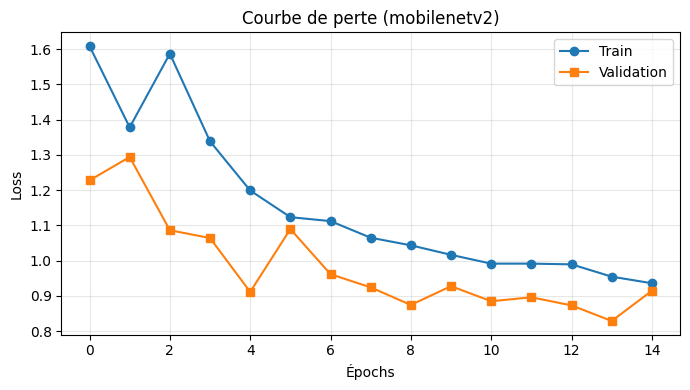

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses, label="Validation", marker="s")
plt.title(f"Courbe de perte ({MODEL_NAME})")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Chargement du meilleur modèle
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
best_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
state_dict = torch.load(best_path, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)
model.eval()
print(f"✅ Meilleur modèle chargé depuis : {best_path}")


✅ Meilleur modèle chargé depuis : /workspace/models/mobilenetv2_best.pt


## Évaluation avec le module cnn_eval

Utilisation du module `p9dg.metrics.cnn_eval` pour automatiser l'évaluation complète :
- Export des prédictions vers CSV
- Ajustement de la température de calibration
- Calcul des métriques (accuracy, F1, ECE, Brier)
- Génération des visualisations (matrice de confusion, reliability diagram)


In [39]:
import sys, os
from pathlib import Path

# Même logique que dans ta cellule 0
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()

# 👉 On ajoute la racine du projet au sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT ajouté à sys.path :", PROJECT_ROOT)


PROJECT_ROOT ajouté à sys.path : /workspace


In [41]:
# Import du module d'évaluation
from metrics.cnn_eval import run_eval_split

# Évaluation complète sur le set de validation
# Cette fonction automatise tout le pipeline :
# 1. Export CSV avec logits et confidences
# 2. Ajustement de la température de calibration (si fit_temperature_on_val=True)
# 3. Calcul des métriques et génération des figures

df_val, report_val = run_eval_split(
    model=model_for_eval,  # Utilise le meilleur modèle (ou SWA si activé)
    dataloader=val_loader,
    device=DEVICE,
    out_dir=OUTPUTS_DIR,
    model_name=MODEL_NAME,
    split="val",
    class_to_idx=train_ds.class_to_idx,
    fit_temperature_on_val=True,  # Ajuste la température sur le set de validation
    make_plots=True
)

# Affichage des résultats
print("\n" + "="*60)
print("📊 RÉSULTATS D'ÉVALUATION")
print("="*60)
print(f"Split              : {report_val.split}")
print(f"Nombre d'échantillons : {report_val.n}")
print(f"\n🎯 Métriques de performance :")
print(f"  Accuracy (micro) : {report_val.acc_micro:.4f}")
print(f"  F1-score (macro) : {report_val.f1_macro:.4f}")
print(f"\n📈 Métriques de calibration :")
print(f"  ECE (brut)       : {report_val.ece_raw:.4f}")
if report_val.ece_cal is not None:
    print(f"  ECE (calibré)    : {report_val.ece_cal:.4f}")
    print(f"  Amélioration ECE : {report_val.ece_raw - report_val.ece_cal:.4f}")
print(f"  Brier (brut)     : {report_val.brier_raw:.4f}")
if report_val.brier_cal is not None:
    print(f"  Brier (calibré)  : {report_val.brier_cal:.4f}")

print(f"\n📄 Fichiers générés :")
print(f"  CSV prédictions  : {OUTPUTS_DIR / f'{MODEL_NAME}_preds_val.csv'}")
print(f"  JSON température : {OUTPUTS_DIR / f'{MODEL_NAME}_temp_scaling.json'}")
if report_val.cm_path:
    print(f"  Matrice confusion: {report_val.cm_path}")
if report_val.reliability_path:
    print(f"  Reliability diag : {report_val.reliability_path}")

print("\n" + "="*60)
print("📋 Rapport de classification :")
print("="*60)
print(report_val.classification_report)


[OK] export → /workspace/outputs/02_baseline_cnn/mobilenetv2_preds_val.csv  (540 lignes)
[OK] Température sauvegardée → /workspace/outputs/02_baseline_cnn/mobilenetv2_temp_scaling.json  (T=0.572)
[OK] export → /workspace/outputs/02_baseline_cnn/mobilenetv2_preds_val.csv  (540 lignes)

📊 RÉSULTATS D'ÉVALUATION
Split              : val
Nombre d'échantillons : 540

🎯 Métriques de performance :
  Accuracy (micro) : 0.9315
  F1-score (macro) : 0.9261

📈 Métriques de calibration :
  ECE (brut)       : 0.1458
  ECE (calibré)    : 0.0267
  Amélioration ECE : 0.1191
  Brier (brut)     : 0.1522
  Brier (calibré)  : 0.1213

📄 Fichiers générés :
  CSV prédictions  : /workspace/outputs/02_baseline_cnn/mobilenetv2_preds_val.csv
  JSON température : /workspace/outputs/02_baseline_cnn/mobilenetv2_temp_scaling.json
  Matrice confusion: /workspace/outputs/02_baseline_cnn/cm_val.png
  Reliability diag : /workspace/outputs/02_baseline_cnn/reliability_val.png

📋 Rapport de classification :
                

In [42]:
# Sauvegarde d'un TorchScript (pour ré-utilisation)
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
scripted = torch.jit.script(model.eval().to(DEVICE))
scripted.save(str(MODELS_DIR / f"{MODEL_NAME}_best_ts.pt"))

In [43]:
# 2️⃣ Prédiction sur le jeu de validation avec paths et logits
from torch.nn.functional import softmax

y_true, y_pred = [], []
logits_list, probs_list, paths_all = [], [], []

use_amp = (getattr(DEVICE, "type", str(DEVICE)) == "cuda")

with torch.inference_mode():
    for imgs, labels, paths in tqdm(val_loader, desc="Évaluation finale"):
        imgs = imgs.to(DEVICE, non_blocking=True)

        if use_amp:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(imgs)
        else:
            outputs = model(imgs)

        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

        # pour la suite (CSV + calibration)
        logits_list.append(outputs.detach().cpu())
        probs_list.append(softmax(outputs.detach(), dim=1).cpu())
        paths_all.extend(paths)



Évaluation finale: 100%|██████████| 135/135 [04:23<00:00,  1.95s/it]


In [44]:
# 3️⃣ Rapport de classification (macro-F1, recall, précision)
classes = list(train_ds.class_to_idx.keys())

print("\n=== Rapport de classification ===")
print(classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0
))



=== Rapport de classification ===
              precision    recall  f1-score   support

         ADI      1.000     1.000     1.000        60
        BACK      0.949     0.933     0.941        60
         DEB      0.896     1.000     0.945        60
         LYM      0.923     1.000     0.960        60
         MUC      0.949     0.933     0.941        60
         MUS      0.671     0.883     0.763        60
        NORM      0.982     0.933     0.957        60
         STR      0.872     0.567     0.687        60
         TUM      0.945     0.867     0.904        60

    accuracy                          0.902       540
   macro avg      0.910     0.902     0.900       540
weighted avg      0.910     0.902     0.900       540



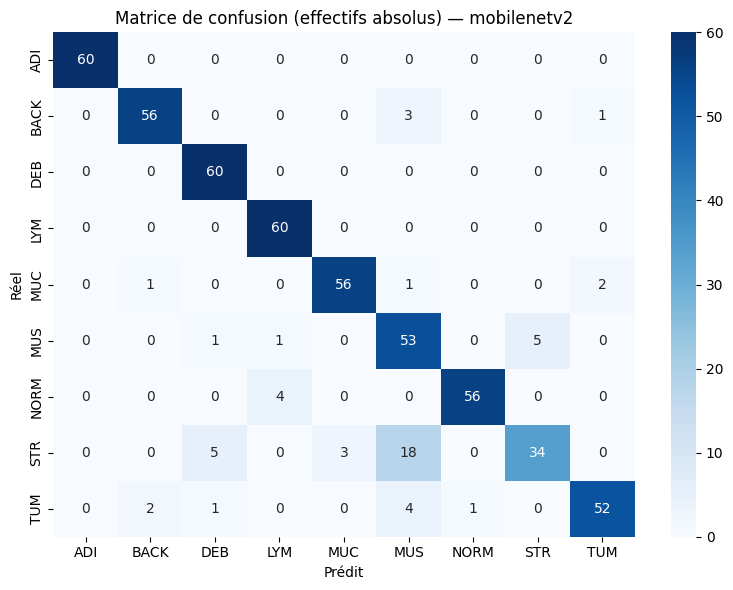

In [45]:
# 4️⃣ Matrice de confusion 

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matrice de confusion (valeurs absolues)
cm = confusion_matrix(y_true, y_pred)  # 👈 pas de normalize ici

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title(f"Matrice de confusion (effectifs absolus) — {MODEL_NAME}")
plt.tight_layout()
plt.show()



### Export des prédictions et logits → CSV

In [46]:
# (optionnel) garantir l'ordre des classes par index
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]


In [47]:
import json, pandas as pd, torch
from pathlib import Path
from torch.nn.functional import softmax

# Empilement
logits_val = torch.cat(logits_list, dim=0)        # (N, C) sur CPU (on a .cpu() plus haut)
probs_val  = torch.cat(probs_list, dim=0)         # (N, C)
y_true_np  = np.array(y_true)
y_pred_np  = np.array(y_pred)

# Sanity-check alignements
assert len(paths_all) == logits_val.shape[0] == probs_val.shape[0] == len(y_true_np) == len(y_pred_np)

# Construction du DataFrame
top1_conf = probs_val.max(dim=1).values.numpy().tolist()
rows = []
for i in range(len(paths_all)):
    rows.append({
        "split": "val",
        "image_path": paths_all[i],
        "y_true": int(y_true_np[i]),
        "y_pred": int(y_pred_np[i]),
        "top1_conf": float(top1_conf[i]),
        "logits_json": json.dumps(logits_val[i].tolist(), separators=(",", ":"))
    })

df_val = pd.DataFrame(rows)
# Utiliser OUTPUTS_DIR défini dans la cellule précédente
if "OUTPUTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "02_baseline_cnn"
out_dir = OUTPUTS_DIR
out_dir.mkdir(parents=True, exist_ok=True)
csv_val = out_dir / f"{MODEL_NAME}_preds_val.csv"
df_val.to_csv(csv_val, index=False)
print(f"[OK] Sauvé: {csv_val}  ({len(df_val)} lignes)")


[OK] Sauvé: /workspace/outputs/02_baseline_cnn/mobilenetv2_preds_val.csv  (540 lignes)


In [48]:
# Sanity: imports (si pas déjà faits)
import numpy as np
from pathlib import Path
import json
import torch
from torch.nn.functional import softmax

C = logits_val.shape[1]
assert C == len(classes), f"Mismatch nb classes: logits C={C} vs classes={len(classes)}"
assert np.all((y_true_np >= 0) & (y_true_np < C)), "y_true hors bornes"
print("OK: dims/classes/labels")

# Vérif chemins
assert all(isinstance(p, str) and len(p) > 0 for p in paths_all), "paths_all contient des valeurs invalides"
print("OK: paths")


OK: dims/classes/labels
OK: paths


In [49]:
probs_from_logits = softmax(logits_val, dim=1).cpu()
delta = (probs_from_logits - probs_val).abs().max().item()
print(f"Δmax(probs_from_logits, probs_val) = {delta:.3e}")

# Si delta trop grand, on fiabilise en remplaçant par softmax(logits_val)
if delta > 1e-6:
    probs_val = probs_from_logits
    print("⚠️ Remplacement de probs_val par softmax(logits_val)")

# Guard NaN/Inf
has_bad = (torch.isnan(logits_val).any() or torch.isinf(logits_val).any() or
           torch.isnan(probs_val).any()  or torch.isinf(probs_val).any())
assert not has_bad, "NaN/Inf détecté dans logits/probs"
print("OK: pas de NaN/Inf")


Δmax(probs_from_logits, probs_val) = 3.052e-05
⚠️ Remplacement de probs_val par softmax(logits_val)
OK: pas de NaN/Inf


In [50]:
# Longueur des vecteurs logits
logits_len_ok = all(len(json.loads(s)) == C for s in df_val["logits_json"])
assert logits_len_ok, "Certaines lignes ont un logits_json de longueur ≠ nb classes"
print("OK: longueur logits_json")

# Chemins dupliqués ?
dups = df_val["image_path"].duplicated().sum()
print(f"Duplications paths: {dups}")


OK: longueur logits_json
Duplications paths: 24


### ECE + Temperature Scaling (fit sur val)

In [51]:
import torch
import numpy as np

def compute_ece(probs, y_true, n_bins=15):
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(y_true)
    ece = torch.zeros(1, device=probs.device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=probs.device)
    for i in range(n_bins):
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        prop = in_bin.float().mean()
        if prop.item() > 0:
            acc_bin = accuracies[in_bin].float().mean()
            conf_bin = confidences[in_bin].mean()
            ece += torch.abs(conf_bin - acc_bin) * prop
    return ece.item()

class TempScaler(torch.nn.Module):
    def __init__(self, init_temp=1.0):
        super().__init__()
        self.log_t = torch.nn.Parameter(torch.tensor(np.log(init_temp), dtype=torch.float32))
    def forward(self, logits):
        return logits / torch.exp(self.log_t)

def fit_temperature(logits_val, y_val, max_iter=1000, lr=0.01):
    scaler = TempScaler().to(logits_val.device)
    opt = torch.optim.LBFGS(scaler.parameters(), lr=lr, max_iter=max_iter, line_search_fn="strong_wolfe")
    criterion = torch.nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad(set_to_none=True)
        loss = criterion(scaler(logits_val), y_val)
        loss.backward()
        return loss
    opt.step(closure)
    return scaler

# Tensors val (sur device pour l’optim)
device_ts = "cuda" if torch.cuda.is_available() else "cpu"
y_val_t = torch.tensor(y_true_np, device=device_ts, dtype=torch.long)
logits_val_t = logits_val.to(device_ts)

# ECE avant calibration
probs_before = torch.softmax(logits_val_t, dim=1)
ece_before = compute_ece(probs_before, y_val_t)

# Fit température sur val
T = fit_temperature(logits_val_t, y_val_t)
temp_value = float(torch.exp(T.log_t).item())
T.eval()  # par sûreté (même si pas de layers spéciaux)

# ECE après calibration
with torch.no_grad():
    probs_after = torch.softmax(T(logits_val_t), dim=1)
ece_after = compute_ece(probs_after, y_val_t)

print(f"Temp* = {temp_value:.3f} | ECE val: {ece_before:.4f} → {ece_after:.4f}")


Temp* = 0.569 | ECE val: 0.1873 → 0.0378


### Sauvegarde de la température + CSV “calibré” 

In [52]:
import json
from pathlib import Path

# 1) Sauvegarder la température
# Utiliser ARTIFACTS_DIR défini dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
with open(ARTIFACTS_DIR / f"{MODEL_NAME}_temp_scaling.json", "w") as f:
    json.dump({"temperature": temp_value}, f)
print(f"[OK] Température sauvegardée → {ARTIFACTS_DIR / f'{MODEL_NAME}_temp_scaling.json'}")

# 2) Export CSV avec confiance calibrée
T.eval()
with torch.no_grad():
    probs_after = torch.softmax(T(logits_val_t), dim=1)

top1_conf_cal = probs_after.max(dim=1).values.cpu().numpy().tolist()

df_val_cal = df_val.copy()
df_val_cal["top1_conf_cal"] = top1_conf_cal
csv_val_cal = out_dir / f"{MODEL_NAME}_preds_val_calibrated.csv"
df_val_cal.to_csv(csv_val_cal, index=False)
print(f"[OK] Sauvé: {csv_val_cal}  ({len(df_val_cal)} lignes)")


[OK] Température sauvegardée → /workspace/artifacts/mobilenetv2_temp_scaling.json
[OK] Sauvé: /workspace/outputs/02_baseline_cnn/mobilenetv2_preds_val_calibrated.csv  (540 lignes)


## Test OOD (sur des images différentes et  non normalisées)

In [53]:
# === Cellule 1 : manifeste OOD échantillonné ===
from pathlib import Path
import csv, random

# Utiliser DATA_ROOT et ARTIFACTS_DIR définis dans la cellule précédente
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

NONORM_DIR = DATA_ROOT / "NCT-CRC-HE-100K-NONORM"  # racine OOD
MANIFEST_OOD_CSV = ARTIFACTS_DIR / "manifest_ood_nonorm.csv"
MANIFEST_OOD_CSV.parent.mkdir(parents=True, exist_ok=True)

# Paramètres d'échantillonnage
SEED = 123
MAX_PER_CLASS_OOD = 200  # ajuste à ta convenance

random.seed(SEED)

# On suppose la même arborescence que NCT : <NONORM_DIR>/<CLASS>/*.png|*.tif|...
exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
rows = []
classes = sorted([d.name for d in NONORM_DIR.iterdir() if d.is_dir()])

for c in classes:
    files = [str(p) for p in (NONORM_DIR / c).iterdir() if p.suffix.lower() in exts]
    if not files:
        continue
    random.shuffle(files)
    take = files[:MAX_PER_CLASS_OOD]
    for fp in take:
        rows.append({"path": fp, "label": c, "split": "test"})  # on marque tout en test (OOD)

with MANIFEST_OOD_CSV.open("w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["path", "label", "split"])
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ Manifeste OOD créé : {MANIFEST_OOD_CSV} ({len(rows)} images, {len(classes)} classes)")


✅ Manifeste OOD créé : /workspace/artifacts/manifest_ood_nonorm.csv (1800 images, 9 classes)


In [54]:
# === Cellule 2 : dataset + loader OOD ===
import torch
from torch.utils.data import DataLoader
from histo_dataset import HistoDataset
from utils.class_mappings import make_idx_mappings

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# IMPORTANT :
# - split_policy='manual_csv' pour pointer vers notre manifeste
# - split='test' car c'est un test OOD
# - no_repeat_eval=True pour figer la sélection (reproductible)
# - samples_per_class_per_epoch pour contrôler l'échantillon OOD
# - vahadane_enable=False pour VRAIMENT tester le décalage "non-normalisé"
SAMPLES_PER_CLASS_PER_EPOCH = 100  # <= peut être différent de MAX_PER_CLASS_OOD

    # Utiliser CONFIG_DIR défini dans la cellule précédente
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

ds_ood = HistoDataset(
    root_data="/",                         # ignoré en mode manual_csv
    split="test",
    split_policy="manual_csv",
    manual_csv=str(MANIFEST_OOD_CSV),
    output_size=IMAGE_SIZE,                       # doit matcher le training
    pixel_range="imagenet",                # idem que le training si tu utilisais ImageNet
    balance_per_class=True,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS_PER_EPOCH,
    no_repeat_eval=True,
    vahadane_enable=False,                 # clé pour OOD "NONORM"
    vahadane_device="cpu",
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),  # OK (n'impacte pas test)
)

# Mappings lisibles
idx_to_name, idx_to_color, name_to_color = make_idx_mappings(ds_ood.class_to_idx)

loader_ood = DataLoader(
    ds_ood,
    batch_size=64,
    shuffle=False,   # le dataset gèle déjà l’échantillon via no_repeat_eval
    num_workers=0,   # ajuste si besoin
    pin_memory=True if DEVICE == "cuda" else False
)

print("Classes OOD :", {i: n for i, n in idx_to_name.items()})
print("Taille OOD  :", len(ds_ood))


✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (100 images / classe).
Classes OOD : {0: 'Tissu adipeux', 1: 'Arrière-plan (fond sans tissu)', 2: 'Débris cellulaires / nécrose', 3: 'Lymphocytes (infiltrat immunitaire)', 4: 'Mucus (sécrétions)', 5: 'Tissu musculaire lisse', 6: 'Muqueuse colique normale', 7: 'Stroma associé au cancer', 8: 'Épithélium adénocarcinomateux (tumeur)'}
Taille OOD  : 900


Chargement du modèle depuis : /workspace/models/mobilenetv2_best.pt
✅ Modèle chargé et prêt pour l'inférence OOD.


Évaluation OOD: 100%|██████████| 15/15 [00:13<00:00,  1.15batch/s]



🎯 Accuracy globale OOD : 0.8889

=== Rapport de classification (OOD) ===
              precision    recall  f1-score   support

         ADI      0.836     0.970     0.898       100
        BACK      0.835     0.960     0.893       100
         DEB      0.955     0.840     0.894       100
         LYM      0.839     0.990     0.908       100
         MUC      0.916     0.760     0.831       100
         MUS      0.907     0.880     0.893       100
        NORM      0.891     0.900     0.896       100
         STR      0.921     0.820     0.868       100
         TUM      0.946     0.880     0.912       100

    accuracy                          0.889       900
   macro avg      0.894     0.889     0.888       900
weighted avg      0.894     0.889     0.888       900

📄 Rapport OOD exporté : /workspace/artifacts/ood_report.csv
📄 CM absolue : /workspace/artifacts/ood_confusion_abs.csv
📄 CM normalisée : /workspace/artifacts/ood_confusion_norm.csv


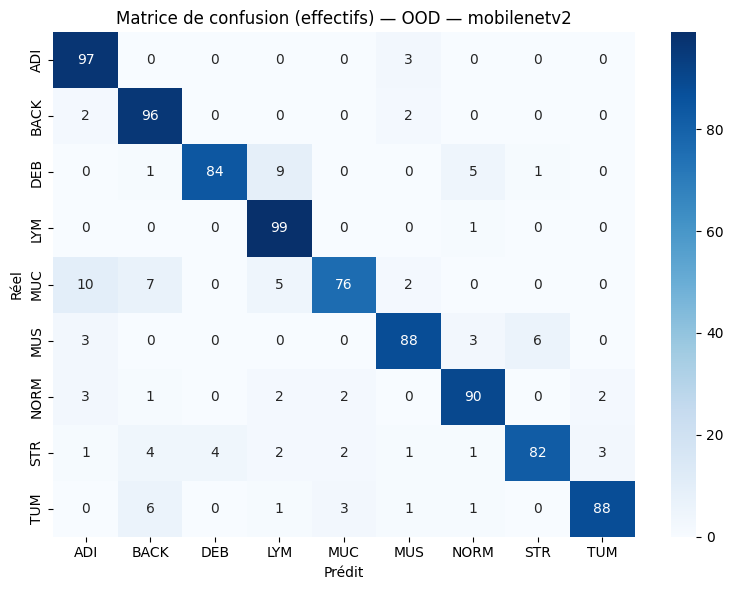

🖼️ CM (absolue) sauvegardée : /workspace/artifacts/figs/ood_cm_abs_mobilenetv2.png


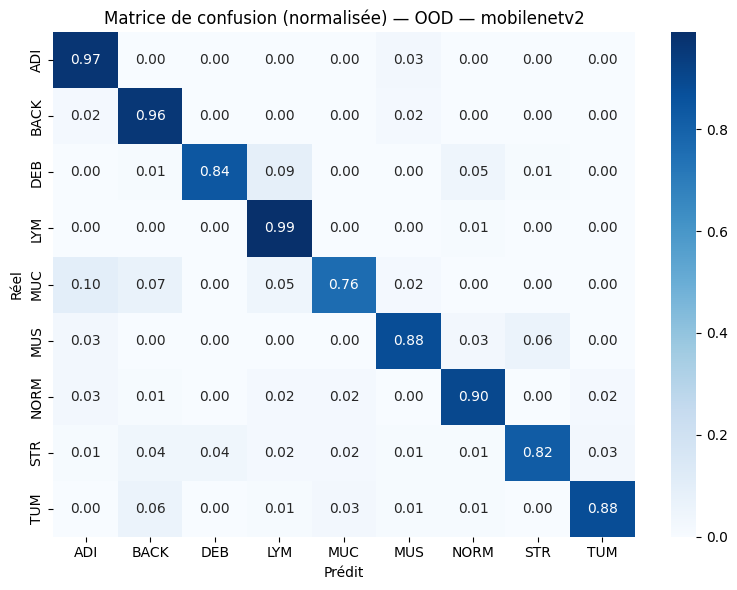

🖼️ CM (normalisée) sauvegardée : /workspace/artifacts/figs/ood_cm_norm_mobilenetv2.png

✅ Inférence OOD terminée.
- Accuracy OOD          : 0.8889
- Export métriques CSV  : ood_report.csv, ood_confusion_abs.csv, ood_confusion_norm.csv
- Figures PNG           : ood_cm_abs_mobilenetv2.png, ood_cm_norm_mobilenetv2.png


In [ ]:
# === Cellule 3 : Inférence OOD complète (métriques + exports) ===
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from contextlib import nullcontext
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Config/export ----------
# Utiliser ARTIFACTS_DIR et MODELS_DIR définis dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
ART_DIR = ARTIFACTS_DIR
ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = ART_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

BEST_PATH = MODELS_DIR / f"{MODEL_NAME}_best.pt"   # doit exister (cf. ton entraînement)
REPORT_CSV = ART_DIR / "ood_report.csv"
CM_ABS_CSV = ART_DIR / "ood_confusion_abs.csv"
CM_NORM_CSV = ART_DIR / "ood_confusion_norm.csv"
CM_ABS_PNG = FIG_DIR / f"ood_cm_abs_{MODEL_NAME}.png"
CM_NORM_PNG = FIG_DIR / f"ood_cm_norm_{MODEL_NAME}.png"

# ---------- Chargement du meilleur modèle ----------
print(f"Chargement du modèle depuis : {BEST_PATH}")
state_dict = None
try:
    # torch>=2.0
    state_dict = torch.load(BEST_PATH, map_location=DEVICE, weights_only=True)
except TypeError:
    # Compat torch<2.0
    state_dict = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval().to(DEVICE)
print("✅ Modèle chargé et prêt pour l'inférence OOD.")

# ---------- Contexte AMP selon device ----------
amp_ctx = torch.amp.autocast(device_type="cuda") if DEVICE.startswith("cuda") else nullcontext()

# ---------- Inférence ----------
y_true, y_pred = [], []
with torch.no_grad(), amp_ctx:
    for imgs, labels, _paths in tqdm(loader_ood, desc="Évaluation OOD", unit="batch"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        # labels peuvent déjà être sur CPU selon ton DataLoader
        y_true.extend(labels.cpu().numpy() if hasattr(labels, "cpu") else labels.numpy())

y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

# ---------- Noms de classes depuis le Dataset OOD (ordre par index) ----------
num_classes = len(ds_ood.class_to_idx)
idx_to_name = {v: k for k, v in ds_ood.class_to_idx.items()}
classes = [idx_to_name[i] for i in range(num_classes)]

# ---------- Métriques globales ----------
acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Accuracy globale OOD : {acc:.4f}")

print("\n=== Rapport de classification (OOD) ===")
rep_txt = classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0
)
print(rep_txt)

# Version DataFrame (pour export)
rep_dict = classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0,
    output_dict=True
)

rep_df = pd.DataFrame(rep_dict).T  # 👈 au lieu de DataFrame.from_dict(..., orient="index")
rep_df["accuracy_global"] = acc    # optionnel : rajouter ta métrique d’accuracy globale
rep_df.to_csv(REPORT_CSV)

print(f"📄 Rapport OOD exporté : {REPORT_CSV}")

# ---------- Matrices de confusion ----------
cm_abs = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))  # absolu
cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize="true")  # normalisée par ligne

pd.DataFrame(cm_abs, index=classes, columns=classes).to_csv(CM_ABS_CSV)
pd.DataFrame(cm_norm, index=classes, columns=classes).to_csv(CM_NORM_CSV)
print(f"📄 CM absolue : {CM_ABS_CSV}")
print(f"📄 CM normalisée : {CM_NORM_CSV}")

# ---------- Visualisations ----------
plt.figure(figsize=(8, 6))
sns.heatmap(cm_abs, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title(f"Matrice de confusion (effectifs) — OOD — {MODEL_NAME}")
plt.tight_layout()
plt.savefig(CM_ABS_PNG, dpi=150)
plt.show()
print(f"🖼️ CM (absolue) sauvegardée : {CM_ABS_PNG}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title(f"Matrice de confusion (normalisée) — OOD — {MODEL_NAME}")
plt.tight_layout()
plt.savefig(CM_NORM_PNG, dpi=150)
plt.show()
print(f"🖼️ CM (normalisée) sauvegardée : {CM_NORM_PNG}")

# ---------- Récapitulatif ----------
print("\n✅ Inférence OOD terminée.")
print(f"- Accuracy OOD          : {acc:.4f}")
print(f"- Export métriques CSV  : {REPORT_CSV.name}, {CM_ABS_CSV.name}, {CM_NORM_CSV.name}")
print(f"- Figures PNG           : {CM_ABS_PNG.name}, {CM_NORM_PNG.name}")


Résumé — FN: 12 (uniques: 8) | FP: 5 (uniques: 3)


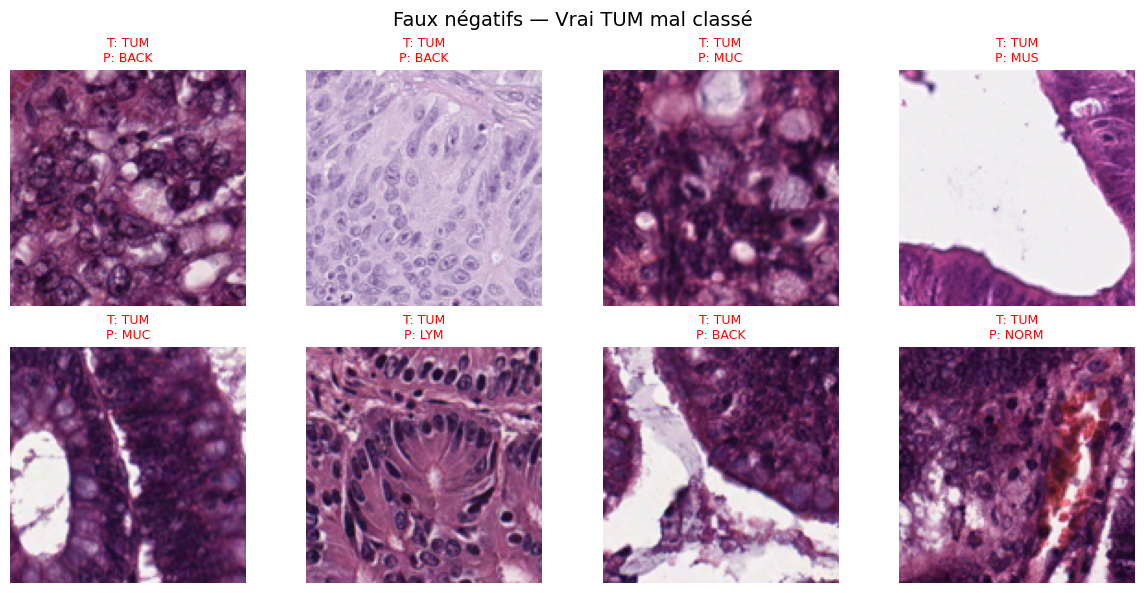

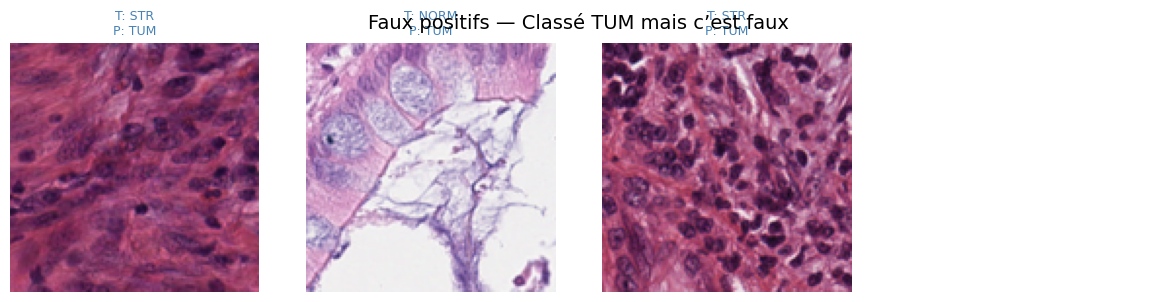

In [ ]:
# 🔎 Déduplication par chemin de fichier (préserve l’ordre d’apparition)
def unique_by_path(indices, ds):
    seen, uniq = set(), []
    for i in indices:
        ci, j = ds._epoch_indices[i]
        p = ds_ood.paths_by_class[ci][j]
        if p not in seen:
            seen.add(p); uniq.append(i)
    return uniq

# ✅ Recalcul des erreurs (inchangé)
tum_idx = [k for k, v in idx_to_name.items() if v == "TUM"][0]
fn_idxs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt == tum_idx and yp != tum_idx]
fp_idxs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != tum_idx and yp == tum_idx]

# ✂️ Dédup pour les figures
fn_idxs_u = unique_by_path(fn_idxs, ds_ood)
fp_idxs_u = unique_by_path(fp_idxs, ds_ood)

print(f"Résumé — FN: {len(fn_idxs)} (uniques: {len(fn_idxs_u)}) | "
      f"FP: {len(fp_idxs)} (uniques: {len(fp_idxs_u)})")

# ✅ Affichage robuste (gère n=0)
def show_images_grid(indices, title, color, ncols=4, image_size=(128, 128), fontsize=9, max_images=8):
    import matplotlib.pyplot as plt

    n = min(len(indices), max_images)

    if n == 0:
        fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
        fig.suptitle(title, fontsize=14)
        ax.text(0.5, 0.55, "Aucun exemple à afficher", ha="center", va="center", fontsize=12)
        ax.text(0.5, 0.25, "\u2713 aucune erreur détectée pour ce cas",  # ✓
                ha="center", va="center", fontsize=10, color=color)
        ax.axis("off")
        plt.tight_layout()
        plt.subplots_adjust(top=0.78)
        plt.show()
        return

    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
    fig.suptitle(title, fontsize=14)

    for ax_idx, ax in enumerate(axes):
        if ax_idx < n:
            idx = indices[ax_idx]
            try:
                ci, j = ds_ood._epoch_indices[idx]
                img, _ = ds_ood._load_path(ci, j)  # charge PIL.Image
                img = img.resize(image_size)
                true_label = idx_to_name[y_true[idx]]
                pred_label = idx_to_name[y_pred[idx]]
                ax.imshow(img)
                ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=fontsize)
            except Exception as e:
                ax.text(0.5, 0.5, f"Erreur chargement\nidx={idx}\n{e}", ha="center", va="center", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# 🖼️ Affichage (sur les listes dédupliquées)
show_images_grid(fn_idxs_u, "Faux négatifs — Vrai TUM mal classé", color="red", ncols=4)
show_images_grid(fp_idxs_u, "Faux positifs — Classé TUM mais c’est faux", color="steelblue", ncols=4)


⚖️ Balanced accuracy OOD : 0.8889


Entropy pass: 100%|██████████| 15/15 [00:13<00:00,  1.09batch/s]


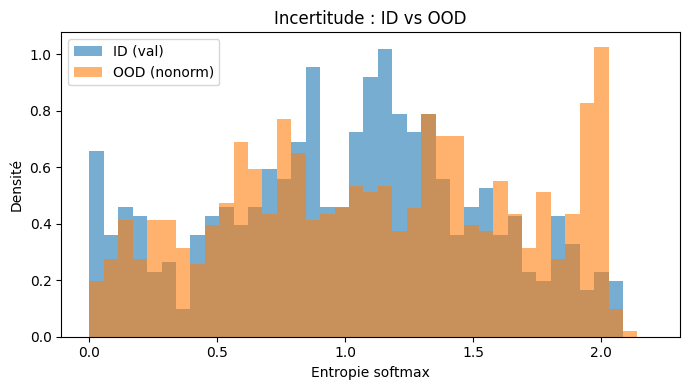

📄 Entropies sauvées dans /workspace/artifacts/uncertainty_*.csv ; figure dans /workspace/artifacts/figs/


In [57]:
# === Balanced accuracy (OOD) ===
from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"⚖️ Balanced accuracy OOD : {bal_acc:.4f}")

# === Entropie softmax : ID (val) vs OOD ===
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

def collect_entropy(loader):
    ent = []
    model.eval()
    with torch.no_grad():
        for imgs, _, _ in tqdm(loader, desc="Entropy pass", unit="batch"):
            logits = model(imgs.to(DEVICE))
            p = F.softmax(logits, dim=1).cpu().numpy()
            # entropie de Shannon, base e
            e = -(p * (np.log(p + 1e-12))).sum(axis=1)
            ent.extend(e.tolist())
    return np.array(ent)

ent_id  = collect_entropy(val_loader)      # ID = validation in-distribution
ent_ood = collect_entropy(loader_ood)      # OOD = NONORM

# Quick viz
plt.figure(figsize=(7,4))
bins = np.linspace(0, np.log(len(classes))+1e-6, 40)  # borne max ~ log(K)
plt.hist(ent_id, bins=bins, alpha=0.6, label="ID (val)", density=True)
plt.hist(ent_ood, bins=bins, alpha=0.6, label="OOD (nonorm)", density=True)
plt.xlabel("Entropie softmax"); plt.ylabel("Densité"); plt.legend()
plt.title("Incertitude : ID vs OOD")
plt.tight_layout()
# Utiliser ARTIFACTS_DIR défini dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
FIG_DIR = ARTIFACTS_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(str(FIG_DIR / "uncertainty_id_vs_ood.png"), dpi=150)
plt.show()

# Sauvegarde CSV pour analyse ultérieure
import pandas as pd
pd.DataFrame({"entropy": ent_id,  "set": "ID"}).to_csv(str(ARTIFACTS_DIR / "uncertainty_id.csv"),  index=False)
pd.DataFrame({"entropy": ent_ood, "set": "OOD"}).to_csv(str(ARTIFACTS_DIR / "uncertainty_ood.csv"), index=False)
print(f"📄 Entropies sauvées dans {ARTIFACTS_DIR}/uncertainty_*.csv ; figure dans {FIG_DIR}/")
